<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)


# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data (unigrams)
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the aticles Metadata
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
# Take a look at the dataframe
articles

,Topic_ID_1,Affiliation_Prob_1,Topic_ID_2,Affiliation_Prob_2,Topic_1,Topic_2
0,1,0.329300,7.0,0.292654,politics_international,economy_international
1,7,0.462487,11.0,0.269677,economy_international,economy_national
2,7,0.325522,11.0,0.232608,economy_international,economy_national
3,7,0.473720,11.0,0.470850,economy_international,economy_national
4,7,0.598861,11.0,0.281546,economy_international,economy_national
...,...,...,...,...,...,...
2441178,17,0.466716,2.0,0.251594,economy_national,inconsequential
2441179,12,0.315961,21.0,0.274781,inconsequential,economy_national
2441180,26,0.377586,29.0,0.296713,sports,law_order
2441181,23,0.433544,13.0,0.272896,tragedies_crimes,law_order


In [6]:
# Get the indexes of the articles that are about Covid (i.e. either articles with Topic_1 = COVID or Topic_2 = COVID and Affiliation_Prob_2 >= 0.25)
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
# Remove the unnecessary variable to save RAM
del articles

In [7]:
# Read in the preprocessed data
de_tx, de_idx = read_preprocessed('de')

# Take a look at the size of the precleaned data
sys.getsizeof(de_tx)

15474568

In [8]:
## Reduce the data to the Covid articles
# Retrieve the location of the Covid article in the preprocessed data
location = de_idx[de_idx.de_idx.isin(Covid_idx)].index.tolist()
# Get the Text Data of the Covid articles
de_tx = itemgetter(*location)(de_tx)
# Reduce the dataframe containing the index to the Covid articles
de_idx = de_idx.iloc[location]
de_idx.set_index(np.arange(de_idx.shape[0]), inplace = True)
# Take a look at how many articles remain
len(de_tx)

109904

In [10]:
# Take a look at the preprocessed data of the Covid articles
de_tx[0][:6]

['spanische',
 'metropole',
 'europäische',
 'hauptstadt',
 'komplett',
 'abriegeln']

In [9]:
# Take a look at the dataframe containing the according index
de_idx.tail(3)

,de_idx
109901,2441168
109902,2441169
109903,2441171


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [11]:
# Create Dictionary
dictionary = corpora.Dictionary(de_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(de_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2738

In [12]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandemie':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

At pos. 189 we find the word coronavirus
At pos. 25 we find the word corona
At pos. 26 we find the word covid
At pos. 117 we find the word virus
At pos. 159 we find the word pandemie


In [13]:
# Create Dictionary
dictionary = corpora.Dictionary(de_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 33% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(de_tx)/100), no_above = 0.33, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2723

In [14]:
# Check whether the most common language specific corona phrases are still contained
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'corona':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break  
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'virus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'pandemie':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break

In [15]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in de_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 4), (46, 1), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 10), (67, 2), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 2), (88, 1), (89, 3), (90, 1), (91, 4), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 3

In [16]:
# Remove unnecessary variables to save RAM
del de_tx, de_idx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [17]:
# Get the phrase corresponding to id 0
dictionary[0]

'abends'

In [18]:
# Get a human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abends', 1),
  ('abriegeln', 1),
  ('ansteckungszahlen', 1),
  ('appellieren', 2),
  ('arbeiten', 1),
  ('arbeiter', 1),
  ('art', 1),
  ('ausbruch', 1),
  ('ausgangssperre', 1),
  ('ausnahmezustand', 1),
  ('bar', 2),
  ('beginnen', 2),
  ('bereit', 1),
  ('berichten', 1),
  ('beschliessen', 1),
  ('beschränken', 1),
  ('beschränkung', 2),
  ('bestätigen', 1),
  ('bett', 1),
  ('bewegen', 1),
  ('bewohner', 1),
  ('bitten', 1),
  ('botschaft', 1),
  ('brauchen', 1),
  ('bürger', 1),
  ('de', 1),
  ('decken', 1),
  ('derzeit', 1),
  ('drastisch', 1),
  ('einbussen', 1),
  ('einwohner', 1),
  ('erfasst', 1),
  ('erklären', 1),
  ('erkrankung', 1),
  ('erneut', 1),
  ('europa', 4),
  ('europäische', 1),
  ('fallzahlen', 1),
  ('frei', 1),
  ('füllen', 1),
  ('gast', 2),
  ('gastronomie', 1),
  ('gesamt', 1),
  ('gesundheitsminister', 1),
  ('grund', 1),
  ('hauptstadt', 4),
  ('haus', 1),
  ('heftig', 1),
  ('hoch', 3),
  ('infektion', 1),
  ('infektionszahlen', 1),
  ('intensivstati

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonable and feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics $\rightarrow$ $\beta$ in Hoffman, Bach & Blei (2010))
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)

In [19]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 10,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  5.426714424292246 minutes


In [20]:
# Save the model to harddisk
lda_model.save("LDA/Covid/de_lda_model_"+str(lda_model.num_topics)+"_topics")

In [21]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

In [22]:
##### Update model using new, unseen documents (Example) #####
#other_texts = [
#    ['computer', 'time', 'graph'],
#    ['survey', 'response', 'eps'],
#    ['human', 'system', 'computer']
#]
#other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

#unseen_doc = other_corpus[0]
#vector = lda_model[unseen_doc]  # get topic probability distribution for a document

# Update the model by incrementally training on the new corpus.
#lda_model.update(other_corpus)  # update the LDA model with additional documents

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/de_lda_model_10_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(0,
  '0.054*"maske" + 0.022*"tragen" + 0.020*"maskenpflicht" + 0.011*"einhalten" '
  '+ 0.011*"abstand" + 0.009*"kunde" + 0.008*"halten" + 0.008*"öffentlich" + '
  '0.006*"meter" + 0.006*"regel"'),
 (1,
  '0.047*"bundesrat" + 0.023*"berset" + 0.012*"alain" + 0.010*"bund" + '
  '0.007*"lage" + 0.007*"öffnen" + 0.006*"fordern" + 0.006*"svp" + '
  '0.006*"gesundheitsminister" + 0.005*"mai"'),
 (2,
  '0.016*"land" + 0.014*"infektion" + 0.012*"million" + 0.011*"usa" + '
  '0.011*"usamerikanischen" + 0.010*"regierung" + 0.010*"china" + '
  '0.010*"sterben" + 0.009*"trump" + 0.009*"italien"'),
 (3,
  '0.016*"positiv" + 0.016*"quarantäne" + 0.012*"absagen" + 0.012*"spieler" + '
  '0.011*"spiel" + 0.011*"swiss" + 0.010*"testen" + 0.009*"stattfinden" + '
  '0.009*"verschieben" + 0.009*"schweizer"'),
 (4,
  '0.018*"kind" + 0.014*"schule" + 0.012*"quarantäne" + 0.012*"patient" + '
  '0.010*"positiv" + 0.008*"spital" + 0.008*"zürich" + 0.008*"testen" + '
  '0.007*"haus" + 0.007*"schüler"'),
 (5,


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/de_lda_model_10_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
de_tx, de_idx = read_preprocessed('de')
location = de_idx[de_idx.de_idx.isin(Covid_idx)].index.tolist()
de_tx = itemgetter(*location)(de_tx)
de_idx = de_idx.iloc[location]
de_idx.set_index(np.arange(de_idx.shape[0]), inplace = True)

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in de_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 10 topics: -7.161587092405386


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = de_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 10 topics: 0.4642015472432221


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.053392 -0.022314       1        1  12.513783
8     -0.026638  0.003603       2        1  12.372028
7      0.046575 -0.077433       3        1  11.717416
2     -0.217067 -0.064685       4        1  11.502082
4      0.064412  0.124131       5        1  10.636609
5      0.069354 -0.020270       6        1   9.233137
1      0.073613 -0.134177       7        1   8.964566
0      0.165077 -0.000123       8        1   8.602179
9     -0.213763  0.014984       9        1   8.092739
3     -0.014955  0.176285      10        1   6.365461, topic_info=               Term          Freq         Total Category  logprob  loglift
320           maske  78533.000000  78533.000000  Default  30.0000  30.0000
635       bundesrat  78860.000000  78860.000000  Default  29.0000  29.0000
629          berset  34202.000000  34202.000000  Default  28.0000  28.0000
588   maskenpflicht  41598.000000  41598.000000  Default  27.0000  27.0000
562             bag  54189.000000  54189.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
359          stehen   7146.663724  57180.194654  Topic10  -4.9541   0.6747
100            test   6708.369894  63894.465875  Topic10  -5.0174   0.5004
1222            sda   5200.216371  19904.990018  Topic10  -5.2720   1.4120
1156         nächst   5526.709721  30742.812078  Topic10  -5.2112   1.0382
1014    entscheiden   5278.842315  24636.304714  Topic10  -5.2570   1.2138

[646 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2416      1  0.006931     abbilden
2416      2  0.082014     abbilden
2416      3  0.006353     abbilden
2416      4  0.017904     abbilden
2416      6  0.008663     abbilden
...     ...       ...          ...
2582      3  0.732502  übertreiben
2582      5  0.017264  übertreiben
2582      7  0.008221  übertreiben
2582      8  0.065769  übertreiben
2582     10  0.000822  übertreiben

[3284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 8, 3, 5, 6, 2, 1, 10, 4])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
de_tx, de_idx = read_preprocessed('de')
location = de_idx[de_idx.de_idx.isin(Covid_idx)].index.tolist()
de_tx = itemgetter(*location)(de_tx)
de_idx = de_idx.iloc[location]
de_idx.set_index(np.arange(de_idx.shape[0]), inplace = True)

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(de_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 33% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(de_tx)/100), no_above = 0.33, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

2723

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in de_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 4), (46, 1), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 10), (67, 2), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 2), (88, 1), (89, 3), (90, 1), (91, 4), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 3

In [8]:
def compare_lda_models(dictionary, corpus, texts, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/Covid/de_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [9]:
# 1. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, de_tx, min_k = 1, max_k = 30, step = 1)

Processing time to build the LDA multicore model with 1 topics: 0.8644830226898194 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.22761426877951116
Processing time to build the LDA multicore model with 2 topics: 4.015423301855723 minutes
Coherence Score of the LDA multicore model with 2 topics: 0.395898186964324
Processing time to build the LDA multicore model with 3 topics: 4.548723793029785 minutes
Coherence Score of the LDA multicore model with 3 topics: 0.4026834204537321
Processing time to build the LDA multicore model with 4 topics: 4.691491798559825 minutes
Coherence Score of the LDA multicore model with 4 topics: 0.42523464492664154
Processing time to build the LDA multicore model with 5 topics: 4.327009212970734 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.45484752990532773
Processing time to build the LDA multicore model with 6 topics: 4.285407511393229 minutes
Coherence Score of the LDA multicore model with 6 topics: 0.469258286876

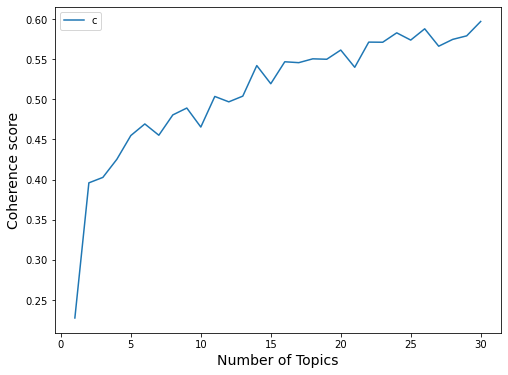

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

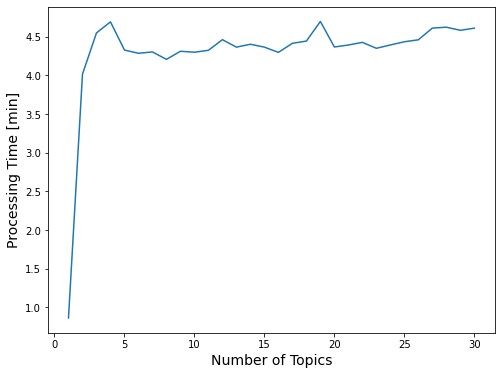

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.22761426877951116,
 0.395898186964324,
 0.4026834204537321,
 0.42523464492664154,
 0.45484752990532773,
 0.4692582868769197,
 0.4552131684147181,
 0.4805246343999161,
 0.48907332826617167,
 0.4653896191982011,
 0.5035083347994034,
 0.49679897944389295,
 0.5039040302812193,
 0.5419676249573439,
 0.5193502568591136,
 0.5466999381425366,
 0.5455899466968868,
 0.5503589270488298,
 0.5498367142668862,
 0.5613031363908516,
 0.5398199584738497,
 0.5711797174465356,
 0.5710345053574354,
 0.5827307488464967,
 0.5737141544466087,
 0.5877548152330087,
 0.5660740699265452,
 0.574569635387045,
 0.5789856921997407,
 0.5968965068492872]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[0.8644830226898194,
 4.015423301855723,
 4.548723793029785,
 4.691491798559825,
 4.327009212970734,
 4.285407511393229,
 4.302787387371064,
 4.206753993034363,
 4.311420555909475,
 4.299012653032938,
 4.324039161205292,
 4.461379798253377,
 4.3648092667261755,
 4.402183242638906,
 4.364772546291351,
 4.297195017337799,
 4.4142003655433655,
 4.443216653664907,
 4.6965914805730185,
 4.366829776763916,
 4.392146420478821,
 4.42673522233963,
 4.349825632572174,
 4.392807594935099,
 4.4342744986216225,
 4.4595893859863285,
 4.610818545023601,
 4.622626574834188,
 4.582401557763418,
 4.609812211990357]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
# Storage of the results for LdaMulticore model with passes = 12
coherence_values = [0.22761426877951116, 0.395898186964324,   0.4026834204537321, 0.42523464492664154, 0.45484752990532773,
                    0.4692582868769197,  0.4552131684147181,  0.4805246343999161, 0.48907332826617167, 0.4653896191982011,
                    0.5035083347994034,  0.49679897944389295, 0.5039040302812193, 0.5419676249573439,  0.5193502568591136,
                    0.5466999381425366,  0.5455899466968868,  0.5503589270488298, 0.5498367142668862,  0.5613031363908516,
                    0.5398199584738497,  0.5711797174465356,  0.5710345053574354, 0.5827307488464967,  0.5737141544466087,
                    0.5877548152330087,  0.5660740699265452,  0.574569635387045,  0.5789856921997407,  0.5968965068492872]
processing_times = [0.8644830226898194, 4.015423301855723,  4.548723793029785,  4.691491798559825,  4.327009212970734,
                    4.285407511393229,  4.302787387371064,  4.206753993034363,  4.311420555909475,  4.299012653032938,
                    4.324039161205292,  4.461379798253377,  4.3648092667261755, 4.402183242638906,  4.364772546291351,
                    4.297195017337799,  4.4142003655433655, 4.443216653664907,  4.6965914805730185, 4.366829776763916,
                    4.392146420478821,  4.42673522233963,   4.349825632572174,  4.392807594935099,  4.4342744986216225,
                    4.4595893859863285, 4.610818545023601,  4.622626574834188,  4.582401557763418,  4.609812211990357]
n_topics = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

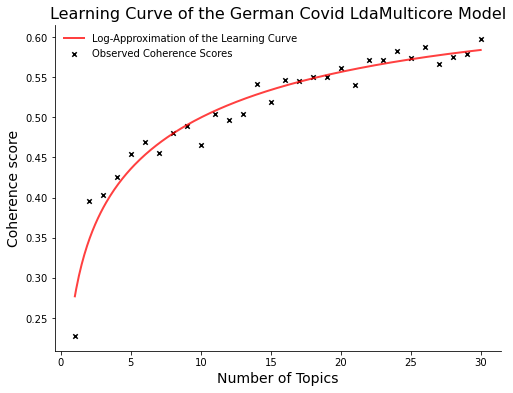

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the German Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

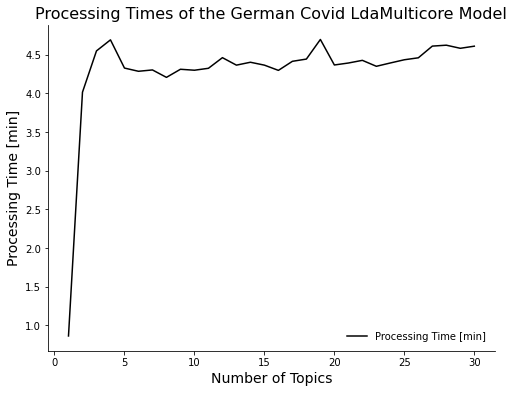

In [8]:
# Show the evolvement of the processing time 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the German Covid LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [9]:
# Get the number of topics from the topic model that exhibits the highest coherence score
opt_n_topic = n_topics[np.argmax(np.array(coherence_values))]
# Display the optimal number of topics
print('The optimal number of topics according to the coherence score is', opt_n_topic)

The optimal number of topics according to the coherence score is 30


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [10]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.45484752990532773,
                    0.4692582868769197,  0.4552131684147181,  0.4805246343999161, 0.48907332826617167, 0.4653896191982011,
                    0.5035083347994034,  0.49679897944389295, 0.5039040302812193, 0.5419676249573439,  0.5193502568591136,
                    0.5466999381425366,  0.5455899466968868,  0.5503589270488298, 0.5498367142668862,  0.5613031363908516,
                    0.5398199584738497,  0.5711797174465356,  0.5710345053574354, 0.5827307488464967,  0.5737141544466087,
                    0.5877548152330087,  0.5660740699265452,  0.574569635387045,  0.5789856921997407,  0.5968965068492872]
processing_times = [4.327009212970734,
                    4.285407511393229,  4.302787387371064,  4.206753993034363,  4.311420555909475,  4.299012653032938,
                    4.324039161205292,  4.461379798253377,  4.3648092667261755, 4.402183242638906,  4.364772546291351,
                    4.297195017337799,  4.4142003655433655, 4.443216653664907,  4.6965914805730185, 4.366829776763916,
                    4.392146420478821,  4.42673522233963,   4.349825632572174,  4.392807594935099,  4.4342744986216225,
                    4.4595893859863285, 4.610818545023601,  4.622626574834188,  4.582401557763418,  4.609812211990357]
n_topics = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [11]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [12]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/Covid/de_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [13]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [14]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

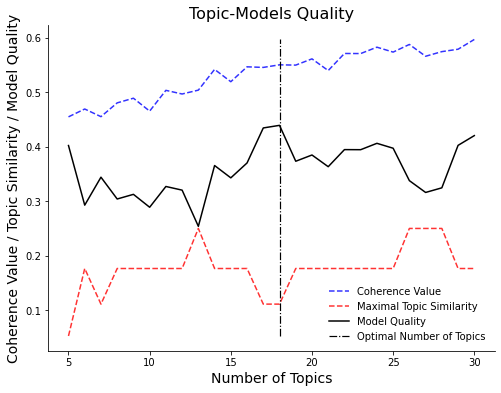

In [15]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Value')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximal Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(max_topic_similarities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Value / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [16]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 18


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 18 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the German articles, this strategy leads us to an optimal choice of $K^* = 22$ for the COVID specific LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 22  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/de_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.113*"maske" + 0.047*"maskenpflicht" + 0.044*"tragen" + 0.013*"öffentlich" '
  '+ 0.011*"abstand" + 0.010*"einhalten" + 0.010*"verkehr" + 0.010*"zug" + '
  '0.009*"halten" + 0.008*"trage"'),
 (1,
  '0.037*"deutschland" + 0.020*"eu" + 0.020*"österreich" + 0.020*"frankreich" '
  '+ 0.020*"land" + 0.014*"deutsch" + 0.012*"merkel" + 0.012*"grenze" + '
  '0.009*"öffnen" + 0.007*"berlin"'),
 (2,
  '0.034*"italien" + 0.022*"swiss" + 0.020*"flug" + 0.019*"schweizer" + '
  '0.017*"tessin" + 0.017*"reise" + 0.016*"passagier" + 0.015*"flughafen" + '
  '0.012*"airline" + 0.012*"land"'),
 (3,
  '0.035*"land" + 0.023*"regierung" + 0.012*"lockdown" + '
  '0.012*"grossbritannien" + 0.009*"million" + 0.008*"spanien" + '
  '0.008*"einwohner" + 0.007*"europa" + 0.007*"region" + 0.007*"schwede"'),
 (4,
  '0.013*"zürich" + 0.013*"bewohner" + 0.013*"haus" + 0.010*"heim" + '
  '0.010*"polizei" + 0.009*"arbeiten" + 0.008*"halten" + 0.008*"mitarbeitende" '
  '+ 0.007*"stadt" + 0.007*"arbeit"'),
 (5,
 

In [6]:
# Read in the preprocessed data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
de_tx, de_idx = read_preprocessed('de')
location = de_idx[de_idx.de_idx.isin(Covid_idx)].index.tolist()
de_tx = itemgetter(*location)(de_tx)
de_idx = de_idx.iloc[location]
de_idx.set_index(np.arange(de_idx.shape[0]), inplace = True)

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in de_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21     0.011933 -0.002556       1        1  7.631577
7      0.085514  0.050190       2        1  7.204156
12     0.081070 -0.085225       3        1  6.758879
8     -0.022119  0.081354       4        1  6.708877
11     0.133552 -0.028790       5        1  5.852567
4      0.136969  0.038441       6        1  5.589641
3     -0.132098 -0.097777       7        1  5.137185
10    -0.288335 -0.004863       8        1  5.066649
15     0.071066 -0.071038       9        1  4.876444
20    -0.047187  0.170455      10        1  4.806981
9     -0.246072  0.052629      11        1  4.598621
0      0.159969  0.043437      12        1  4.104652
5      0.064606 -0.197251      13        1  4.092541
6      0.053474  0.082140      14        1  3.968891
17     0.010840  0.093398      15        1  3.892937
1     -0.075942 -0.186368      16        1  3.425557
14     0.016691  0.177252      17        1  3.238928
2     -0.054537 -0.087063      18        1  2.846829
16    -0.102196  0.053877      19        1  2.697196
18    -0.018825  0.025999      20        1  2.691946
13     0.135373  0.019418      21        1  2.441110
19     0.026255 -0.127659      22        1  2.367835, topic_info=            Term          Freq         Total Category  logprob  loglift
320        maske  76334.000000  76334.000000  Default  30.0000  30.0000
100         test  62172.000000  62172.000000  Default  29.0000  29.0000
635    bundesrat  74346.000000  74346.000000  Default  28.0000  28.0000
837         kind  35915.000000  35915.000000  Default  27.0000  27.0000
150   quarantäne  62297.000000  62297.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
215     mittwoch   2625.768188  30493.366025  Topic22  -4.9665   1.2911
1305        lage   2739.326255  40420.380802  Topic22  -4.9241   1.0516
493         bern   2382.157700  31740.099708  Topic22  -5.0638   1.1536
77        region   2101.673836  22927.700086  Topic22  -5.1891   1.3536
1749      martin   2028.645160   9479.267174  Topic22  -5.2245   2.2015

[1177 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2220      5  0.012870        aarau
2220     14  0.211739        aarau
2220     20  0.065182        aarau
2220     22  0.709949        aarau
120      12  0.001367       aargau
...     ...       ...          ...
2582      6  0.037763  übertreiben
2582      7  0.030683  übertreiben
2582     10  0.169934  übertreiben
2582     12  0.016521  übertreiben
2582     16  0.018095  übertreiben

[9707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 8, 13, 9, 12, 5, 4, 11, 16, 21, 10, 1, 6, 7, 18, 2, 15, 3, 17, 19, 14, 20])

In [9]:
# Delete unnecessary variables
del de_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore returen a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [11]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 1.047102189064026 minutes


In [12]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 1.0436433951059978 minutes


In [13]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = de_idx.de_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Covid/Topic_Assignment/de_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 22  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/Covid/de_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Covid/Topic_Assignment/de_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed fulltext data of the Covid articles
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = [0,11,12,13,14,15,16])
Covid_idx = articles.loc[np.logical_or(articles['Topic_1'] == 'COVID', 
                                       np.logical_and(articles['Topic_2'] == 'COVID', 
                                                      articles['Affiliation_Prob_2'] >= 0.25))].index
del articles
de_tx_fulltext, de_idx = read_preprocessed_fulltext('de')
location = de_idx[de_idx.de_idx.isin(Covid_idx)].index.tolist()
de_tx_fulltext = itemgetter(*location)(de_tx_fulltext)
de_idx = de_idx.iloc[location]
de_idx.set_index(np.arange(de_idx.shape[0]), inplace = True)

In [8]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

In [131]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5):
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [9]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(0,
 [('maske', 0.11291001),
  ('maskenpflicht', 0.046920046),
  ('tragen', 0.04363511),
  ('öffentlich', 0.0129393125),
  ('abstand', 0.011138664),
  ('einhalten', 0.009876256),
  ('verkehr', 0.0098132305),
  ('zug', 0.009659605),
  ('halten', 0.00865002),
  ('trage', 0.008331416),
  ('schutzmasken', 0.0075276075),
  ('öv', 0.0071266256),
  ('schutz', 0.007095428),
  ('bus', 0.0070062783),
  ('pflicht', 0.006975954),
  ('sbb', 0.006871125),
  ('schützen', 0.006519557),
  ('empfehlen', 0.0062598907),
  ('meter', 0.0062396354),
  ('mund', 0.0057751536)])


[' Die SBB zeigt sich in einer ersten Bilanz zufrieden mit der Umsetzung der Maskenpflicht im öffentlichen Verkehr. Praktisch alle Reisenden hätten eine Maske getragen, sagte SBB Sprecher Daniele Pallecchi gegenüber Keystone SDA. Offenbar seien alle über die ab Montag geltende Maskenpflicht im öffentlichen Verkehr informiert gewesen. Gemäss ersten Rückmeldungen des Fahrpersonals hätten nur Vereinzelte keine Maske getragen. […]Die SBB zeigt sich in einer ersten Bilanz zufrieden mit der Umsetzung der Maskenpflicht im öffentlichen Verkehr. Praktisch alle Reisenden hätten eine Maske getragen, sagte SBB Sprecher Daniele Pallecchi gegenüber Keystone SDA. Offenbar seien alle über die ab Montag geltende Maskenpflicht im öffentlichen Verkehr informiert gewesen. Gemäss ersten Rückmeldungen des Fahrpersonals hätten nur Vereinzelte keine Maske getragen. Diese seien auf die neue Pflicht hingewiesen worden. Oftmals hätten sich dann Mitreisende solidarisch gezeigt und eine der eigenen Masken ausgehän

In [10]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(1,
 [('deutschland', 0.03660456),
  ('eu', 0.0204041),
  ('österreich', 0.020009179),
  ('frankreich', 0.019855132),
  ('land', 0.019583626),
  ('deutsch', 0.01424547),
  ('merkel', 0.012402391),
  ('grenze', 0.012390361),
  ('öffnen', 0.008521408),
  ('berlin', 0.0073035453),
  ('regierung', 0.0070017423),
  ('angela', 0.0066780187),
  ('staat', 0.006631303),
  ('italien', 0.006499209),
  ('lockdown', 0.006409183),
  ('schweizer', 0.006228642),
  ('euro', 0.005459762),
  ('geschäft', 0.0053267),
  ('macron', 0.0053241327),
  ('europa', 0.005103047)])


[' Deutschlands Bundesländer setzen Angela Merkel unter Druck. Punkto Coronalockerungen scheint Bundeskanzlerin Angela Merkel die Zügel aus der Hand zu geben. Verschiedene Bundesländer preschen in diesen Tagen entgegen dem Willen Berlins mit eigenen Lockerungen vor. Mecklenburg Vorpommern will schon Ende Mai wieder Ferien an der Ostseeküste erlauben, Niedersachsen öffnet am Montag einen Teil seiner Restaurants, Nordrhein Westfalen will die Kleinsten wieder in die Kita schicken, in Bayern soll man wieder golfen und Tennis spielen dürfen und Sachsen Anhalt erlaubt Treffen von kleinen Menschengruppen. Merkel, die für Deutschland am liebsten eine einheitliche Linie in der Coronakrise gefahren wäre, kann das nicht passen. Schon vor zwei Wochen hatte sie sich in CDU internen Debatten über die Öffnungsdiskussionsorgien aufgeregt. Doch die Rufe nach einem raschen Ausweg aus dem Lockdown werden inzwischen auch in ihren eigenen Parteireihen lauter. Deshalb berät Merkel heute mit den Ministerpräs

In [11]:
# Further highly ranked articles of topic 1
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 40, show_n_last_elements = 4)

[' Die in der Corona Krise eingeführten Kontrollen an deutschen Grenzen werden bis zum 4. Mai verlängert, wie das Bundesinnenministerium in Berlin mitteilt. Die Kontrollen an den Grenzen zu Österreich, Frankreich, Luxemburg, Dänemark und der Schweiz wurden gegen die Ausbreitung des Coronavirus vor einem Monat eingeführt. Menschen, die weder deutsche Staatsbürger sind noch dauerhaft in Deutschland wohnen, […]Die in der Corona Krise eingeführten Kontrollen an deutschen Grenzen werden bis zum 4. Mai verlängert, wie das Bundesinnenministerium in Berlin mitteilt. Die Kontrollen an den Grenzen zu Österreich, Frankreich, Luxemburg, Dänemark und der Schweiz wurden gegen die Ausbreitung des Coronavirus vor einem Monat eingeführt. Menschen, die weder deutsche Staatsbürger sind noch dauerhaft in Deutschland wohnen, dürfen wegen der Corona Pandemie nur noch aus einem triftigen Reisegrund nach Deutschland einreisen. Die Einreise ist zudem nur über bestimmte Grenzübergänge möglich. ',
 ' Angela Merk

In [12]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(2,
 [('italien', 0.03444871),
  ('swiss', 0.021643385),
  ('flug', 0.019662969),
  ('schweizer', 0.018547483),
  ('tessin', 0.016840652),
  ('reise', 0.01663367),
  ('passagier', 0.016103767),
  ('flughafen', 0.015428688),
  ('airline', 0.011870808),
  ('land', 0.01151643),
  ('tessiner', 0.011478182),
  ('grenze', 0.010082297),
  ('reisende', 0.008355567),
  ('flugzeug', 0.008274876),
  ('lufthansa', 0.008140081),
  ('tourist', 0.0076046167),
  ('rom', 0.0075659114),
  ('italienisch', 0.006657489),
  ('lombardei', 0.0059386916),
  ('fliegen', 0.005903675)])


[' Die Fluggesellschaft Swiss streicht alle Flüge nach Italien. Die Massnahme gelte bis Anfang April, teilt Swiss mit. Betroffen seien rund 90 wöchentliche Flüge. Wegen des Coronavirus hatte die Swiss bereits letzte Woche Flüge nach Italien gestrichen. Die Swiss gab zudem bekannt, dass auch Destinationen in andere europäische Länder ausgesetzt werden. Die ganze Lufthansa Gruppe streicht wegen […]Die Fluggesellschaft Swiss streicht alle Flüge nach Italien. Die Massnahme gelte bis Anfang April, teilt Swiss mit. Betroffen seien rund 90 wöchentliche Flüge. Wegen des Coronavirus hatte die Swiss bereits letzte Woche Flüge nach Italien gestrichen. Die Swiss gab zudem bekannt, dass auch Destinationen in andere europäische Länder ausgesetzt werden. Die ganze Lufthansa Gruppe streicht wegen des Coronavirus bis zum 24. April insgesamt 23’000 Flüge. Auch die SBB hat ihr Angebot nach Italien reduziert. Seit Dienstag enden die direkten Züge aus der Schweiz nach Venedig in Mailand. Und ab Donnerstag 

In [13]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(3,
 [('land', 0.0346835),
  ('regierung', 0.022690224),
  ('lockdown', 0.011956373),
  ('grossbritannien', 0.0115594),
  ('million', 0.00900437),
  ('spanien', 0.008244684),
  ('einwohner', 0.0075815707),
  ('europa', 0.0071984543),
  ('region', 0.0068138153),
  ('schwede', 0.006763895),
  ('johnson', 0.0066304393),
  ('hoch', 0.006457927),
  ('neuinfektionen', 0.006113893),
  ('stark', 0.005778847),
  ('lage', 0.0055651413),
  ('welle', 0.005272288),
  ('stadt', 0.0051961215),
  ('britische', 0.004899724),
  ('bevölkerung', 0.004817249),
  ('israel', 0.0047244187)])


[' Ein Viertel in Palma de Mallorca wurde wegen steigender Corona Fallzahlen abgeriegelt. Das Quartier mit 23’000 Einwohnern beherbergt hauptsächlich Migranten; es war laut spanischen Medien bereits seit Jahren vernachlässigt worden. vor 17minCorona Ausbruch:Lockdown Quartier auf Mallorca wurde seit Jahren vernachlässigtEin Viertel in Palma de Mallorca wurde wegen steigender Corona Fallzahlen abgeriegelt. Das Quartier mit 23’000 Einwohnern beherbergt hauptsächlich Migranten; es war laut spanischen Medien bereits seit Jahren vernachlässigt worden. Bianca Lüthy1 / 6Das Quartier Son Gotleu in Palma de Mallorca wurde abgeriegelt. Keystone23’000 Personen dürfen ihr Quartier nur noch für Arztbesuche, für die Schule oder die Arbeit verlassen. (Symbolbild)GoogleDie Einschränkungen gelten zunächst für zwei Wochen. Darum gehtsIn Mallorca wurde ein Quartier wegen steigender Corona Fälle abgeriegelt. Vom Lockdown sind 23’000 Personen betroffen. Laut spanischen Medien wurde das Arbeiter und Migrant

In [14]:
# Further highly ranked articles of topic 3
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' Die Niederlande verlängern den Lockdown um weitere drei Wochen bis zum 9. Februar. Das kündigte Ministerpräsident Mark Rutte an. Die Zahl der Neuinfektionen sei zwar vier Wochen nach Verhängung des Lockdowns etwas zurückgegangen, doch das reiche nicht. Hinzu kämen grosse Sorgen über die britische Virus Mutation. Deshalb würden auch verschärfende Massnahmen wie eine abendliche Ausgangssperre nicht […]Die Niederlande verlängern den Lockdown um weitere drei Wochen bis zum 9. Februar. Das kündigte Ministerpräsident Mark Rutte an. Die Zahl der Neuinfektionen sei zwar vier Wochen nach Verhängung des Lockdowns etwas zurückgegangen, doch das reiche nicht. Hinzu kämen grosse Sorgen über die britische Virus Mutation. Deshalb würden auch verschärfende Massnahmen wie eine abendliche Ausgangssperre nicht ausgeschlossen. Seit Mitte Dezember gelten in den Niederlanden strenge Corona Massnahmen. Gaststätten, Geschäfte und Schulen sind geschlossen. Persönliche Kontakte ausserhalb des eigenen Haushal

In [15]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(4,
 [('zürich', 0.013254544),
  ('bewohner', 0.013023139),
  ('haus', 0.012524562),
  ('heim', 0.010408655),
  ('polizei', 0.00987742),
  ('arbeiten', 0.008859686),
  ('halten', 0.0084391525),
  ('mitarbeitende', 0.0076999776),
  ('stadt', 0.007038526),
  ('arbeit', 0.007037908),
  ('situation', 0.0069203647),
  ('einhalten', 0.006678938),
  ('alter', 0.006444023),
  ('homeoffice', 0.006428976),
  ('mitarbeiter', 0.006420623),
  ('besuch', 0.006401471),
  ('zürcher', 0.0057298387),
  ('leute', 0.0057106595),
  ('alt', 0.005584535),
  ('angehörige', 0.0053492812)])


[' In Zeiten von Corona hat die Polizei alle Hände voll zu tun. Polizeisprecher Florian Grossmann gibt einen Überblick. Mit Florian Grossmann sprachAndreas SeeholzerIn der Bevölkerung gibt es aktuell Bürger, die der Polizei melden, wenn sich jemand nicht an die Covid 19 Verordnung hält. Stimmt das?Viele Bürger wollen helfen und setzen Meldungen über Menschenansammlungen ab. Welche Hinweise werden häufig gemacht?Die Hinweise betreffen zum Beispiel das Fussballspielen auf Sportplätzen, Menschenansammlungen am See, Menschenansammlungen auf öffentlichen Plätzen, Grillpartys oder geöffnete Verkaufsgeschäfte. Gibt es auch Hinweise, die aus Sicht der Polizei überflüssig sind?Oftmals ist eine abschliessende Beurteilung einer Situation nur aufgrund eines Telefonanrufes durch einen Bürgers auf der Zentrale gar nicht möglich. Mit unseren Patrouillen sind wir aber rasch vor Ort und können die Situation klären. Meldungen sind das Eine. Kommt es nun aber auch zu vermehrtem Denunzieren von Nachbarn? 

In [16]:
# Further highly ranked articles of topic 4
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 15, show_n_last_elements = 5)

[' Olten Wegen zunehmender Verstösse gegen die Verordnungen des Bundesrates liess der Oltner Stadtrat am Freitag den Ländiweg auf dem rechten Aareufer bis auf weiteres sperren. Immer mehr Gruppen hatten sich dort aufgehalten, welche die Vorschriften im Zusammenhang mit dem Coronavirus bezüglich Anzahl und Distanz zwischen den einzelnen Personen nicht einhielten. Zudem wurden bei Schulanlagen und öffentlichen Parks Plakate aufgestellt, die aufrufen, die Weisungen des Bundesrates Gruppen von maximal 5Personen mit Abständen von zwei Metern untereinander einzuhalten. (sko/otr)',
 ' Zürich | Weil sich viele Zürcherinnen und Zürcher nicht an die Social Distancing Regeln halten, greift die Stadt jetzt zum Absperrband: Mehrere Gebiete und Pärke werden für die Bevölkerung kurzerhand gesperrt. Betreten verboten heisst es ab sofort am Ufer des Zürichsees. Auch die Bäckeranlage und die Fritschiwiese darf nicht mehr fürs gemütliche Draussensitzen genutzt werden. Zudem werden die Stühle auf dem Müns

In [17]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(5,
 [('restaurant', 0.025449181),
  ('bar', 0.018522348),
  ('club', 0.015242879),
  ('maskenpflicht', 0.01361456),
  ('dezember', 0.013130136),
  ('veranstaltung', 0.0131217465),
  ('schliessen', 0.0127397925),
  ('öffentlich', 0.012210091),
  ('schließen', 0.01196063),
  ('privat', 0.011516713),
  ('regel', 0.011004634),
  ('skigebiete', 0.010667851),
  ('gast', 0.009601888),
  ('bern', 0.008400929),
  ('verbieten', 0.008318151),
  ('verschärfen', 0.007964934),
  ('treffen', 0.007814636),
  ('schliessung', 0.007603227),
  ('erlauben', 0.0075096274),
  ('weihnachten', 0.0074903914)])


[' Coronavirus Der Bundesrat hat das Heft wieder in die Hand genommen und am Freitag folgende Einschränkungen verfügt, die ab heute Samstag und vorerst bis zum 22. Januar 2021 gelten:Sperrstunde: Restaurants, Bars, Läden, Märkte, Museen, Bibliotheken sowie Sport und Freizeitanlagen müssen zwischen 19 und 6 Uhr schliessen. Ausnahmen: Kantonen mit günstiger epidemiologischen Entwicklung ist es erlaubt, die Sperrstunde bis auf 23 Uhr auszuweiten. Sonntagsschliessungen: Läden, Märkte, Museen, Bibliotheken sowie Sport und Freizeitanlagen bleiben an Sonn und Feiertagen geschlossen. Hingegen dürfen Restaurants und Bars sonntags geöffnet sein. Veranstaltungsverbot: Öffentliche Anlässe werden verboten. Ausgenommen sind religiöse Feiern (bis 50 Personen), Beerdigungen, Versammlungen von Legislativen und politische Kundgebungen. Sportrestriktionen: Aktivitäten in der Freizeit sind nur noch in Gruppen bis höchstens 5 Personen erlaubt. Am heftigsten fallen die Reaktionen aus der Gastrobranche aus: 

In [18]:
# Further highly ranked articles of topic 5
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 5)

[' Der Kanton Wallis verlängert seine strengeren Corona Massnahmen bis am 13. Dezember, trotz einem Rückgang der Infektionszahlen. Unter anderem weiterhin geschlossen bleiben Restaurants sowie Unterhaltungs und Freizeiteinrichtungen. Versammlungen von mehr als zehn Personen sind im Wallis untersagt. Der Kanton Wallis verlängert seine strengeren Corona Massnahmen bis am 13. Dezember, trotz einem Rückgang der Infektionszahlen. Unter anderem weiterhin geschlossen bleiben Restaurants sowie Unterhaltungs und Freizeiteinrichtungen. Versammlungen von mehr als zehn Personen sind im Wallis untersagt. ',
 ' Im Kampf gegen die Ausbreitung des Coronavirus verschärft auch der Kanton Bern die Massnahmen. Er hat am Freitag unter anderem Veranstaltungen von mehr als 15 Personen verboten und eine Sperrstunde in der Gastronomie von 23 Uhr bis 6 Uhr verfügt. vor 30minBars und Fitnesscenter schliessen:Bern beschliesst drastische MassnahmenIm Kampf gegen die Ausbreitung des Coronavirus verschärft auch der 

In [19]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(6,
 [('patient', 0.045518152),
  ('spitäler', 0.02724862),
  ('spital', 0.022329992),
  ('intensivstation', 0.018986436),
  ('spitälern', 0.017432265),
  ('personal', 0.01363722),
  ('bett', 0.01086107),
  ('situation', 0.009917367),
  ('welle', 0.008895865),
  ('kapazität', 0.008856518),
  ('derzeit', 0.008268882),
  ('kantonsspital', 0.006808698),
  ('arzt', 0.0067740325),
  ('stehen', 0.0066900896),
  ('behandeln', 0.0064062993),
  ('aktuell', 0.0062005254),
  ('klinik', 0.005932721),
  ('zürich', 0.005500025),
  ('behandlung', 0.005486547),
  ('patientin', 0.005457808)])


[' Das Universitätsspital Zürich schliesst die speziell für Covid 19 Patienten geschaffene Intensivstation. Auch andere Krankenhäuser bauen Kapazitäten ab. Pascal Ritter / ch mediaAdrian EngDie Schichten von Pfleger Stefan Turnheer* wurden gestrichen. Seine Dienste auf der Corona Station eines grossen Schweizer Spitals sind nicht mehr gefragt. Sein Dienstplan wurde umgestaltet. So wie Turnheer geht es vielen Angestellten des Gesundheitswesens, die bisher an der Corona Front standen. Denn am Montag machen die Krankenhäuser wieder einen Schritt Richtung Normalität. Wurden bisher nur Notfälle behandelt, finden nun auch planbare Eingriffe wieder statt. Gleichzeitig werden die für den einen Ansturm von Corona Patienten geschaffenen Kapazitäten zum Teil massiv abgebaut. Triemli Spital baut zwei Drittel der isolierten Betten abDas UniversitätsspitalZürichreduziert die Anzahl Intensivbetten, die für Corona Patienten reserviert sind, von 69 auf 16 Betten. Die extra im Hinblick auf einen Andrang

In [20]:
# Further highly ranked articles of topic 6
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 3)

[' BERN. Der Kanton Bern warnt: Die Spitäler könnten bereits in zwei Wochen voll sein. Gestern verzeichnete der Kanton Bern 512 neue Corona Fälle. Das sind so viele wie noch nie und doppelt so viele wie in den letzten Tagen. Zurzeit steigt auch die Zahl der Hospitalisierten rasant an. Bei der Erhebung am Montag waren es noch 82, gestern bereits 121 Menschen. Bisher wurden Covid 19 Patienten nur im Uni Spital Insel und dem Stadtspital Tiefenau behandelt. Dort wird der Platz jedoch langsam eng: Bei uns haben sich die Einweisungen von Covid Patienten seit der letzten Woche verdoppelt, und wir erwarten eine weitere Steigerung. Wir bauen darum unsere Kapazitäten aus, so Adrian Grob, Sprecher der Inselgruppe. Konkret würden an Covid 19 Erkrankte nun auch in anderen Spitälern untergebracht und gepflegt. Gabriel Waldegg, Leitender Arzt Medizin und Infektiologie am Spitalverbund Emmental, sieht viel Arbeit auf sein Team zukommen: Wegen der hohen Positivitätsrate der Abstriche ist eine deutliche

In [139]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(7,
 [('krise', 0.014281437),
  ('leben', 0.009128603),
  ('sehen', 0.0082096895),
  ('stehen', 0.0072598928),
  ('leute', 0.007135834),
  ('finden', 0.006668469),
  ('halten', 0.0055992845),
  ('zeigen', 0.0053847944),
  ('angst', 0.005361336),
  ('nehmen', 0.005299719),
  ('einfach', 0.00529529),
  ('mal', 0.005209615),
  ('bild', 0.004736881),
  ('medium', 0.004283202),
  ('politik', 0.0041902736),
  ('bringen', 0.0041431934),
  ('wissen', 0.00402012),
  ('hören', 0.004005252),
  ('monat', 0.0039842916),
  ('sagen', 0.003931354)])


[' In einem neuen Insta Video sitzt Madonna in einer Badewanne, umringt von Rosenblättern. Und sinniert über das Wesen des Coronavirus. Am Sonntag teilte Madonna (61) ein Video von sich auf Instagram. Sie sitzt nackt in einer Badewanne. Und drückt ihre Emotionen zur momentanen Corona Pandemie aus. Sie nennt das Coronavirus den great equalizer, den grossen Gleichmacher. Das ist die Sache mit Covid 19: Es ist dem Virus egal, wie reich, berühmt, witzig und schlau du bist, erzählt sie, während im Hintergrund leise Musik läuft. Es ist ihm egal, wo du lebst, wie alt du bist, was für schöne Geschichten du erzählen kannst. Es ist der grosse Gleichmacher, fährt sie fort. Sie hält sich im milchigen Wasser an den Wasserhähnen fest und spricht weiter: Das, was so schlimm an dem Virus ist, ist das, was so gut an ihm ist \x96 er macht uns alle gleich. Und weiter: Wir sitzen alle im selben Boot. Wenn dieses Boot untergeht, gehen wir alle unter. (Quelle: Instagram/Madonna)Gemischte ReaktionenZum Video

In [21]:
# Further highly ranked articles of topic 7
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 5)

[' Küsnacht Wie soll man persönlich die Corona Krise bewältigen? Dieser Frage ist das Pfarrpaar Andrea Marco Bianca und Katharina Hoby während des ersten Lockdown nachgegangen. Daraus entstanden ist das Buch Hoffnungszeichen in Krisenzeiten, in dem 50 Persönlichkeiten aus der ganzen Schweiz über Corona Schlagzeilen, Bibelzitate und ihre eigenen Erlebnisse philosophieren. (cle) Seite 7',
 ' LOS ANGELES. Miley Cyrus hat Alkohol und Drogen schon seit längerem abgeschworen, nun hatte sie aber während der Pandemie einen Rückfall. In einem Interview in der Beats 1 Radioshow von Apple Music sprach die Sängerin mit Host Zane Lowe (47) darüber, dass sie wieder zur Flasche gegriffen hatte: Wie viele andere bin auch ich während der Pandemie rückfällig geworden. Ich fühlte mich gar nicht gut in dieser Zeit, so die 28 Jährige. Sie akzeptiere ihren Rückfall und wolle ihren Fans nicht vorspielen, dass sie die ganze Zeit nüchtern war. Seit zwei Wochen habe sie aber keinen Tropfen mehr getrunken. PLKSä

In [22]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(8,
 [('prozent', 0.015054813),
  ('zeigen', 0.011855108),
  ('fallzahlen', 0.010993569),
  ('lockdown', 0.010351731),
  ('welle', 0.010158903),
  ('taskforce', 0.010039615),
  ('hoch', 0.0089032315),
  ('bevölkerung', 0.008049878),
  ('studie', 0.007303686),
  ('stark', 0.0072962376),
  ('wert', 0.006979675),
  ('liegen', 0.006526906),
  ('deutlich', 0.0061015617),
  ('steigen', 0.0052749445),
  ('sehen', 0.005266425),
  ('mutation', 0.004948692),
  ('leute', 0.00486315),
  ('variante', 0.00480898),
  ('infektion', 0.0047516976),
  ('ansteckungen', 0.004743969)])


[' Das Corona Virus breitet sich sehr schnell aus exponentiell, wie es immer heisst. Eine Erklärung. Man falte ein A4 Blatt in der Mitte. Danach nochmals, und so weiter, sodass ein immer kleineres, dickeres Gebilde entsteht. Wie oft gelingt das Zusammenfalten? Mit Mühe siebenmal. War das Papier anfänglich einen Zehntelmillimeter dick, ist das Gebilde nun mehr als einen Zentimeter dick. Das nennt sich exponentielles Wachstum, und es widerstrebt der Intuition. Der Mensch neigt dazu, ein solches Wachstum zu unterschätzen. Dabei sind solche Kurven überall zu finden. Sie erklären die Bevölkerungsexplosion und stehen hinter den Zinseszinsen. Und sie bilden ab, wie sich die Corona Epidemie ausbreitet. Die Kurve mit der Anzahl Infizierten zeigt nach oben, immer steiler. Steckt eine infizierte Person im Schnitt drei Personen an, hat sie innert eines Monats bereits rund tausend infiziert. Mathematisch nennt sich das exponentielle Ausbreitung, im Volksmund heisst es schlicht und treffend explosio

In [23]:
# Further highly ranked articles of topic 8
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 15, show_n_last_elements = 2)

[' Coronavirus Bereits weiche Massnahmen drückten erheblich auf die Ansteckungsrate. Die Massnahmen zur Eindämmung der Coronavirus Pandemie zeigen Wirkung. Das bestätigen nun Analysen der ETH Zürich und der Uni Bern. Bei den Ansteckungen ist die Welle demnach seit Mitte März in einer Abwärtsbewegung. Dabei zeigt sich, dass bereits vor dem Lockdown am 16. März weichere Massnahmen wie Social Distancing, Händewaschen und Selbstisolation Wirkung zeigten. Gemäss den Berechnungen der ETH Professorin Tanja Stadler verlangsamte sich das exponentielle Wachstum der Neuansteckungen schon davor. Am Tag der drastischen Massnahmen war demnach eine Stabilisierung erreicht. Die Forscherin warnt allerdings davor, die Daten überzuinterpretieren, da sie mit beachtlichen Unsicherheiten behaftet sind. Es sei zwar anzunehmen, dass ein Rückgang bereits vor dem Lockdown eingesetzt habe, so Stadler. Sie betont aber, dass es ohne die jetzt gültigen harten Einschränkungen nicht möglich gewesen wäre, die Zahl der

In [24]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(9,
 [('bag', 0.038218454),
  ('melden', 0.025513113),
  ('prozent', 0.023751061),
  ('liegen', 0.016379539),
  ('positiv', 0.015539511),
  ('gesundheit', 0.014246558),
  ('todesfälle', 0.0139446035),
  ('bundesamt', 0.013708232),
  ('steigen', 0.012931303),
  ('neuinfektionen', 0.0118002575),
  ('test', 0.011694026),
  ('insgesamt', 0.009802367),
  ('infektion', 0.009647074),
  ('schnitt', 0.009449913),
  ('wert', 0.009406302),
  ('aktuell', 0.008739292),
  ('ansteckungen', 0.008644322),
  ('hoch', 0.008297444),
  ('stunde', 0.008279341),
  ('vorwoche', 0.008182258)])


[" Experten von BAG, EDA und VBS informieren zur aktuellen Lage. Wir berichten laufend. Auch heute treten Amtschefs und Experten vor die Medien: Ab 14 Uhr im Videostream. Das Wichtigste in Kürze:In der Schweiz hat die Zahl der bestätigten Neuinfektionen mit dem Coronavirus innerhalb eines Tages erneut nur um 254 zugenommen. Insgesamt gibt es damit am Dienstag 25'834 bestätigte Fälle. Die Todesfälle in Zusammenhang mit einer Covid 19 Erkrankung nahmen nach einer Zählung der Nachrichtenagentur Keystone SDA bis am Dienstagmittag um 34 auf 1152 zu. LIVE TICKER254 neue bestätigte Covid 19 FälleIn der Schweiz hat die Zahl der bestätigten Neuinfektionen mit dem Coronavirus innerhalb eines Tages erneut nur um 254 zugenommen. Insgesamt gab es damit am Dienstag 25'834 bestätigte Fälle. Bereits auf Montag waren die Zahlen nur um 280 bestätigte Infektionen gestiegen, auf Sonntag um 400. Doch die Fallzahlen seien am Wochenende jeweils tiefer, relativierte das Bundesamt für Gesundheit (BAG) am Diens

In [25]:
# Further highly ranked articles of topic 9
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 3)

["(Aktualisiert: Zahlen im 2. Abschnitt nach dem Lead. ) In der Schweiz und in Liechtenstein hat die Zahl der bestätigten Neuinfektionen mit dem Coronavirus innerhalb eines Tages um 346 zugenommen. Insgesamt gab es laut laut BAG am Freitag 27'078 bestätigte Fälle. Damit stieg die Zahl der neuen bestätigten Fälle im Vergleich zum Vortag an, wie das Bundesamt für Gesundheit (BAG) weiter mitteilte. Mindestens 3205 Personen waren im Zusammenhang mit einer laborbestätigten Covid 19 Erkrankung hospitalisiert. Die Todesfälle nahmen nach einer Zählung der Nachrichtenagentur Keystone SDA bis Freitagabend innerhalb von 24 Stunden um 37 auf 1319 zu. Der Kanton Waadt überholte erstmals den bisherigen Rekordhalter Tessin und gab die Zahl seiner Todesopfer mit 279 an, im Tessin starben bis Freitag 270 Menschen an der Lungenkrankheit. Keystone SDA analysiert die auf den Internetseiten der Kantone vorliegenden offiziellen Daten und aktualisiert sie zweimal täglich, mittags und abends. Obwalden und App

In [26]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(10,
 [('infektion', 0.023066683),
  ('usa', 0.019402787),
  ('sterben', 0.015061951),
  ('million', 0.015025221),
  ('usamerikanischen', 0.014178338),
  ('land', 0.013149516),
  ('new', 0.011561459),
  ('steigen', 0.010917465),
  ('china', 0.010442428),
  ('tote', 0.010213985),
  ('angabe', 0.00973684),
  ('york', 0.008948441),
  ('weltweit', 0.008538464),
  ('twitter', 0.008278115),
  ('todesfälle', 0.007987906),
  ('bestätigen', 0.007894211),
  ('teilen', 0.007891374),
  ('who', 0.007564812),
  ('the', 0.007401569),
  ('melden', 0.007297303)])


[" Die Universität Johns Hopkins in Baltimore zählt weltweit über 30 Millionen Corona Infektionen. 943’000 Menschen sind an den Folgen von Covid 19 gestorben. vor 15minCovid 19:Über 30 Millionen Corona Infektionen weltweitDie Universität Johns Hopkins in Baltimore zählt weltweit über 30 Millionen Corona Infektionen. 943’000 Menschen sind an den Folgen von Covid 19 gestorben. Weltweit 942’000 Todesfälle: Arbeiter bringen in New York Leichen in einen Kühlwagen. Keystone/Craig RuttleSeit Beginn der Corona Pandemie sind nach Angaben von US Wissenschaftlern weltweit mehr als 30 Millionen Infektionen mit dem Coronavirus verzeichnet worden. Das geht aus Daten der Universität Johns Hopkins in Baltimore vom Donnerstagabend hervor. Die Zahl der Toten liegt demnach bei mehr 943'000. Weltweit entfallen die meisten Infektionen und Todesfälle auf die USA, ein Land mit rund 330 Millionen Einwohnern. In den USA gibt es Johns Hopkins zufolge bislang mehr als 6,6 Millionen Infektionen mit dem Erreger Sa

In [27]:
# Further highly ranked articles of topic 10
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 3)

[' In den USA sind bereits mehr als 22 000 Menschen nach einer Infektion mit dem Coronavirus gestorben. Die Universität Johns Hopkins in Baltimore verzeichnete bis zum Sonntagabend 22 073 Todesfälle. Damit haben die Vereinigten Staaten weiter die höchste absolute Zahl von Todesopfern infolge der Corona Pandemie weltweit. An zweiter Stelle steht Italien mit zuletzt 19 899 Todesfällen. Die Zahl der Todesfälle innerhalb eines Tages in den USA sank mit 1557 unterdessen auf den niedrigsten Stand seit vergangenem Montag. In den 24 Stunden zwischen Donnerstag und Freitagabend (Ortszeit) hatte die Zahl der Todesfälle bisher einmalig die 2000er Marke überstiegen. Knapp 560 000 Infektionen mit dem Coronavirus, das die Lungenkrankheit Covid 19 auslösen kann, wurden der Universität zufolge bisher in den Vereinigten Staaten nachgewiesen. Weltweit sind nach Daten der Forscher in Baltimore mittlerweile rund 1,85 Millionen Menschen mit dem Virus infiziert. Mehr als 114 000 Menschen starben. Die Websei

In [28]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(11,
 [('öffnen', 0.014841786),
  ('kunde', 0.011941996),
  ('gast', 0.011615259),
  ('betrieb', 0.010380172),
  ('restaurant', 0.009866799),
  ('lockdown', 0.009130661),
  ('geschäft', 0.0075619277),
  ('schließen', 0.0072960416),
  ('hotel', 0.0071814475),
  ('leute', 0.007070685),
  ('läden', 0.0060714325),
  ('stehen', 0.005894111),
  ('bild', 0.005005922),
  ('hoffen', 0.004581877),
  ('sehen', 0.0044722934),
  ('situation', 0.004450911),
  ('branche', 0.00418783),
  ('schweizer', 0.0039729895),
  ('derzeit', 0.0039128144),
  ('mai', 0.0038998374)])


[' Bern lockert Regeln Am Samstag durften erstmals wieder 34 einzelne Marktstände in Bern Lebensmittel anbieten. Walter Stettler ist guter Laune. An seinem Stand Stettler Obst kann er am Samstag auf dem Bundesplatz Früchte und Gemüse anbieten. Der Präsident des Vereins Bärner Märit hat dafür gekämpft, dass wir Bauern unsere Ware nicht verderben lassen müssen, weil wir sie nicht verkaufen können. Die Stadt Bern ist den Landwirten nach sechs Wochen Lockdown entgegengekommen: Seit dem 25. April dürfen sie an insgesamt 28 zusätzlichen einzelnen Marktständen wieder Lebensmittel verkaufen 24 davon sind in der Innenstadt, 4 in den Quartieren (Fussgängerzone Bümpliz, Mittelstrasse, Europaplatz, Gilberte de Courgenay Platz). Zuvor konnten nur sechs Anbieter verteilt auf das ganze Stadtgebiet einen Stand aufstellen. Ein richtiges Märit Feeling kommt allerdings nicht auf. Auf dem Bundesplatz beispielsweise, wo in normalen Zeiten 50 Stände dicht an dicht stehen, sind jetzt höchstens drei erlaubt. 

In [29]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(12,
 [('bundesrat', 0.058402978),
  ('berset', 0.029290218),
  ('bund', 0.018027801),
  ('alain', 0.016307715),
  ('lage', 0.010530222),
  ('gesundheitsminister', 0.0077071167),
  ('fordern', 0.006792671),
  ('situation', 0.0066500064),
  ('sommaruga', 0.0063570924),
  ('svp', 0.0062927655),
  ('bevölkerung', 0.0062609324),
  ('gestern', 0.005525384),
  ('können', 0.0053214086),
  ('parmelin', 0.0050072093),
  ('lockdown', 0.00498417),
  ('bundesrats', 0.004946854),
  ('entscheid', 0.0049096136),
  ('wirtschaft', 0.0048727077),
  ('gesundheit', 0.0047707087),
  ('müssen', 0.0043282905)])


[' Der Bund konsultiert in den nächsten Tagen die Kantone zu schärferen Massnahmen im Kampf gegen das Coronavirus auch auf nationaler Ebene. Das sagte Gesundheitsminister Alain Berset am Donnerstag nach einem Treffen mit der Gesundheitsdirektorenkonferenz (GDK). Berset betonte, dass die ""besondere Lage"" aufrechterhalten werde, sodass die Kantone jederzeit ein Mitspracherecht haben. Übers Wochenende werde gemeinsam evaluiert, welche weitere Massnahmen es brauche. ""Der Bundesrat entscheidet dann am Mittwoch. ""Der Gesundheitsminister liess durchblicken, dass weitere nationale Massnahmen notwendig sein werden. ""Das Virus wird sich nicht an Kantonsgrenzen halten"", sagte er vor den Bundeshausmedien. Die Situation sei weiterhin ernst. Die Corona Fälle und die Spitaleinweisungen verdoppelten sich weiter innert Wochenfrist. Die Kurve müsse abflachen, das Gesundheitswesen, die Bevölkerung insbesondere die Risikopersonen müssten geschützt werden. ""Wir wissen, wie wir reagieren müssen. "" D

In [145]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(13,
 [('kind', 0.08646937),
  ('schule', 0.074231826),
  ('schüler', 0.03210916),
  ('eltern', 0.024957767),
  ('fernunterricht', 0.016790006),
  ('klasse', 0.016396727),
  ('unterricht', 0.0137948515),
  ('schülerin', 0.01358241),
  ('lehrer', 0.011780441),
  ('lehrpersonen', 0.011411941),
  ('jugendliche', 0.011302997),
  ('haus', 0.00878117),
  ('erwachsene', 0.008395523),
  ('präsenzunterricht', 0.00814635),
  ('kita', 0.0073212087),
  ('familie', 0.0068998854),
  ('lehrerin', 0.0066574253),
  ('steiner', 0.0054901345),
  ('schließen', 0.0051655043),
  ('montag', 0.0051626777)])


[' Gymnasien Ab heute ist auch an Gymnasien und Berufsschulen wieder Präsenzunterricht möglich. Ursprünglich erlaubte der Bund die Wiederaufnahme nur mit einem strengen Schutzkonzept, denn Jugendliche gelten bei Corona als gleich stark gefährdet wie Erwachsene. Zu den Auflagen gehört, dass konsequent zwei Meter Abstand eingehalten werden. Dies hätte zur Folge, dass an den Schulen je nach räumlichen Verhältnissen nur teilweise Präsenzunterricht möglich ist. Ausgerechnet heute wird der Bund aber ein neues Schutzkonzept veröffentlichen. Darin steht nur noch, dass der 2 Meter Abstand wann immer möglich eingehalten werden muss. Der Satz zum teilweisen Präsenzunterricht wurde gestrichen. Gymnasien und Berufsschulen können ab sofort wieder voll darauf setzen. Für eine Abschwächung des Schutzkonzepts haben sich die Kantone eingesetzt. (ldc/gr) Seite 5',
 ' Bildung Ab heute ist auch an Gymnasien und Berufsschulen wieder Präsenzunterricht möglich. Ursprünglich erlaubte der Bund die Wiederaufnahm

In [30]:
# Further highly ranked articles of topic 13
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' In dieser Schule im zürcherischen Lindau häufen sich die Corona Fälle bei Kindern und Lehrpersonen. Zwei von acht Klassen sind bereits in Quarantäne. Laut Lehrpersonen würden die Hygienemassnahmen schlecht umgesetzt und die Masken seien qualitativ mangelhaft. Der Schulpräsident spielt den Ball zum Kanton. Dieser sieht kein Handlungsbedarf. vor 22minZwei Klassen in Quarantäne:Diese Zürcher Schule bleibt trotz Corona Fällen geöffnetIn dieser Schule im zürcherischen Lindau häufen sich die Corona Fälle bei Kindern und Lehrpersonen. Zwei von acht Klassen sind bereits in Quarantäne. Laut Lehrpersonen würden die Hygienemassnahmen schlecht umgesetzt und die Masken seien qualitativ mangelhaft. Der Schulpräsident spielt den Ball zum Kanton. Dieser sieht kein Handlungsbedarf. (Video: Philip Salzmann)43',
 ' Corona Der Bundesrat wartet zu mit der Schliessung der Schulen. Im Interview begrüsst das Silvia Steiner, Präsidentin der Erziehungsdirektorenkonferenz. Sie sieht keinen Grund, die Schulen 

In [31]:
## Topic 14
# Define the id of the topic of interest
id_focal_topic = 14
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(14,
 [('test', 0.077888906),
  ('testen', 0.03468315),
  ('app', 0.023205671),
  ('schnelltests', 0.021875793),
  ('positiv', 0.010986141),
  ('lassen', 0.010911242),
  ('symptom', 0.010696753),
  ('bag', 0.010486681),
  ('armee', 0.009845962),
  ('pcr', 0.009517673),
  ('einsatz', 0.008842153),
  ('apotheke', 0.008666363),
  ('negativ', 0.007965984),
  ('bund', 0.0076889354),
  ('können', 0.0076196655),
  ('labor', 0.0075509255),
  ('roche', 0.0064248205),
  ('durchführen', 0.006067771),
  ('resultat', 0.0058590285),
  ('schnelltest', 0.0055636847)])


[' Seit dieser Woche läuft der Test für eine Smartphone App, die warnt, wenn man mit jemandem in Kontakt war, der mit dem Coronavirus infiziert ist. Das wirft verschiedene Fragen auf. Eine davon: Was soll man tun, wenn man so eine Warnung erhält? Dann soll man sich kostenlos auf das Virus oder Antikörper testen lassen können, fordert […]Seit dieser Woche läuft der Test für eine Smartphone App, die warnt, wenn man mit jemandem in Kontakt war, der mit dem Coronavirus infiziert ist. Das wirft verschiedene Fragen auf. Eine davon: Was soll man tun, wenn man so eine Warnung erhält? Dann soll man sich kostenlos auf das Virus oder Antikörper testen lassen können, fordert nun die Gesundheitskommission des Nationalrats. Das Parlament wird die gesetzlichen Grundlagen für die App ab der nächsten Woche beraten. Erst wenn das geschehen ist, kann die sogenannte Tracing App offiziell lanciert werden. ',
 ' Coronavirus II Die Swiss Covid App hat nach rund zwei Wochen eine Million aktive Nutzer. Das sag

In [32]:
# Further highly ranked articles of topic 14
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' Corona Seit einigen Tagen bietet die Saner Apotheke in Zusammenarbeit mit dem drop in lab direkt bei der Markthalle Corona Schnelltests an. Sie ist eine von sechs Apotheken, die das Basler Gesundheitswesen mit einem solchen Angebot entlasten. Die Nachfrage ist gross, erst kürzlich wurde im eigens für die Abstriche aufgestellten Testzelt die Kapazität erhöht. Aufgepasst werden muss laut Apotheker Dominik Saner, dass die Schnelltests nur durchgeführt werden, wenn die betreffende Person tatsächlich Coronatypische Symptome hat. Der Test macht Sinn für diejenigen, die Symptome entwickeln und schnell wissen möchten, ob sie Corona haben oder nicht, so Saner. Vor den Festtagen wird ein grosser Ansturm erwartet, auch von Leuten, welche symptomfrei sind und sich mit einem negativen Schnelltest für die bevorstehende Familienfeier absichern wollen. In einem solchen Fall kann ein negativer Befund jedoch trügerisch sein, gibt Saner zu bedenken, da die Testperson dennoch Viren haben könnte, aber n

In [33]:
## Topic 15
# Define the id of the topic of interest
id_focal_topic = 15
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 3)

(15,
 [('luzern', 0.018741261),
  ('absagen', 0.014303523),
  ('märz', 0.014295764),
  ('stattfinden', 0.012297352),
  ('mai', 0.011617343),
  ('luzerner', 0.011316427),
  ('veranstaltung', 0.0113151),
  ('finden', 0.009729725),
  ('april', 0.009085313),
  ('verschieben', 0.008454372),
  ('durchführen', 0.007909198),
  ('aktuell', 0.007859052),
  ('mitteilung', 0.0075423955),
  ('juni', 0.0073087825),
  ('entscheiden', 0.007211134),
  ('gemeinde', 0.007119014),
  ('situation', 0.006926828),
  ('teilen', 0.0066574616),
  ('entscheid', 0.006565299),
  ('veranstalter', 0.0063521275)])


['schwingen Im Verbandsgebiet des Innerschweizer Schwingerverbands finden heuer keine Kantonalschwingfeste statt. Wie der Verband vergangene Woche mitteilte, werden die Anlässe allesamt um ein Jahr verschoben. Das Coronavirus wirft auch den Terminkalender der Schwinger gehörig über den Haufen. Gemäss Informationen auf der Homepage der Schwingerzeitung Schlussgang hatten bis Ende der vergangenen Woche schon knapp 100 Schwingfeste (Aktive und Nachwuchs) abgesagt oder verschoben werden müssen. Betroffen sind längst nicht mehr nur kleinere Hallen, Vorbereitungs und Rangschwinget, sondern auch diverse Kranzfeste. Innerschweizer Kantonalschwingfeste um ein Jahr verschobenIn der Innerschweiz startet die Kranzfestsaison traditionsgemäss mit den fünf Kantonalschwingfesten. Heuer hätte das Zuger Kantonale in Baar am 3. Mai den Anfang gemacht und mit dem Urner Kantonalen in Erstfeld am 7. Juni wäre der Reigen geschlossen worden. Unter anderem hätte am Sonntag, 24. Mai, auch das 101. Luzerner Kant

In [34]:
# Further highly ranked articles of topic 15
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' Matzendorf Die Auswirkungen des Coronavirus sorgen in der Region für die Absage eines weiteren Grossanlasses: Das Organisationskomitee der Kantonalen Schwingfeste in Matzendorf reagiert vorzeitig und verschiebt den Sportanlass auf Mitte September. Bis mindestens Ende April sind nach bundesrätlicher Verordnung alle Veranstaltungen untersagt und es ist wahrscheinlich, dass die Massnahmen verlängert werden. Die Unsicherheit, ob das Kantonale Schwingfest vom 15. bis 17. Mai hätte stattfinden können, wäre zu gross gewesen. Die Gesundheit und das Wohlergehen aller Athleten, Besucher, Funktionäre und Helfer soll und muss geschützt werden und steht für uns klar an erster Stelle, schreibt das OK, das den Grossanlass gemeinsam mit dem Schwingklub Thal Gäu seit zwei Jahren vorbereitet. In der ganzen Region war eine gewisse Vorfreude zu spüren, schreibt das OK. Tickets behalten ihre GültigkeitIm Gegensatz zu vielen anderen Anlässen ist das Schwingfest aber nicht abgesagt, sondern bloss aufgesch

In [35]:
## Topic 16
# Define the id of the topic of interest
id_focal_topic = 16
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(16,
 [('impfstoff', 0.050637912),
  ('impfen', 0.03679584),
  ('trump', 0.023250943),
  ('impfung', 0.022808038),
  ('usamerikanischen', 0.017938761),
  ('präsident', 0.015972795),
  ('million', 0.015780509),
  ('impfungen', 0.015032083),
  ('januar', 0.013652278),
  ('pfizer', 0.013077598),
  ('biontech', 0.012041811),
  ('dose', 0.011479239),
  ('moderna', 0.010427896),
  ('impfdosen', 0.010285723),
  ('dezember', 0.010079518),
  ('lassen', 0.009076859),
  ('usa', 0.008603372),
  ('zulassung', 0.007905063),
  ('donald', 0.007167288),
  ('erhalten', 0.0069358014)])


[' Ein weiterer Hersteller eines Corona Impfstoffs hat Daten zur Wirksamkeit vorgelegt. Der US Pharmakonzern Moderna teilt mit, der Impfstoff biete zu 94,5 Schutz vor Covid 19. Es handelt sich um Zwischenergebnisse aus der Studie, die für eine Zulassung eines Impfstoffes relevant ist. Moderna erwartet, in den nächsten Wochen in den USA eine Notfallgenehmigung zu erhalten. Die Schweiz hat […]Ein weiterer Hersteller eines Corona Impfstoffs hat Daten zur Wirksamkeit vorgelegt. Der US Pharmakonzern Moderna teilt mit, der Impfstoff biete zu 94,5 Schutz vor Covid 19. Es handelt sich um Zwischenergebnisse aus der Studie, die für eine Zulassung eines Impfstoffes relevant ist. Moderna erwartet, in den nächsten Wochen in den USA eine Notfallgenehmigung zu erhalten. Die Schweiz hat einen Vertrag mit Moderna über 4,5 Mio. Dosen des möglichen Impfstoffs abgeschlossen. Die EU verhandelt über bis zu 160 Mio. Dosen. Vor einer Woche hatten die deutsche Firma Biontech und der Pharmakonzern Pfizer mitget

In [36]:
## Topic 17
# Define the id of the topic of interest
id_focal_topic = 17
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(17,
 [('quarantäne', 0.062239565),
  ('contact', 0.02958337),
  ('tracing', 0.028960695),
  ('positiv', 0.01624513),
  ('kontakt', 0.013153764),
  ('testen', 0.011348525),
  ('bag', 0.009064928),
  ('liste', 0.008689883),
  ('bund', 0.008392628),
  ('zürich', 0.00802431),
  ('infizieren', 0.00703957),
  ('hauri', 0.0064254077),
  ('behörde', 0.0062654004),
  ('isolation', 0.005998609),
  ('melden', 0.005971743),
  ('begeben', 0.005892594),
  ('anstecken', 0.0058828695),
  ('kantonsarzt', 0.0056566554),
  ('fallzahlen', 0.0055506607),
  ('gesundheit', 0.005342847)])


[' Pandemie Mehr als jeder zweite Reisende aus einem Risikoland kommt der Quarantänepflicht nicht nach. Nun fordert der oberste Kantonsarzt Rudolf Hauri systematischere Kontrollen und eine Aufklärungskampagne. Es kann jederzeit wieder zu einem exponentiellen Anstieg der Fallzahlen kommen, betonte Hauri in einem Interview mit der NZZ am Sonntag. Dazu brauche es einzig einen neuen Superspreader Event in einem Club oder ein Rückreisender, der unbemerkt andere Menschen anstecke. Hauri geht davon aus, dass sich weniger als die Hälfte der Menschen, die aus Risikoländern in die Schweiz zurückreisen, in Quarantäne begeben. Vor allem wenn man bedenke, dass zahlreiche Reisende aus dem Balkan über die Landgrenze einreisten. Dass es Stichproben an den Grenzen gibt, hat laut Hauri eine wichtige Signalwirkung. Aber der Bund müsse systematischer aus jedem Flugzeug und Bus eine Stichprobe ziehen. Die Reisenden müssen merken, dass es jeden treffen kann. Hauri fordert eine nationale Aufklärungskampagne.

In [37]:
# Further highly ranked articles of topic 17
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 3)

[' Die Zahl der Risikoländer hat sich von 29 auf 42 erhöht. Für Reisende aus diesen Ländern besteht Quarantäne\xadpflicht. Bern Seit dem 6. Juli muss sich bei den Behörden melden, wer aus einem Land einreist, das auf der Quarantäne Liste des Bundes steht. Doch wurden in den letzten Tagen Quarantäne Sünder entlarvt: Während die einen sich gar nie für die Quarantäne angemeldet haben, igno\xadrierten andere danach deren Regeln. Zürich hat deswegen bereits mehrere Personen verzeigt. Im Extremfall kann dieses Verhalten Bussen von bis zu 10 000 Franken zur Folgen haben. Die Rückmeldungen aus den Kantonen zeigen aber auch: Viele Reisende nehmen die Quarantäne Liste inzwischen ernst. vau/TABericht Seite 17',
 ' SCHWYZ. Die Corona Fallzahlen sind im Kanton Schwyz übers Wochenende stark gestiegen. Deshalb muss das Contact Tracing angepasst werden. Die Corona Infizierten müssen neu selbst Personen informieren, mit denen sie in Kontakt standen. Der Kanton teilte gestern zudem mit, dass positiv Get

In [38]:
## Topic 18
# Define the id of the topic of interest
id_focal_topic = 18
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(18,
 [('positiv', 0.03340658),
  ('spieler', 0.023744639),
  ('quarantäne', 0.022475783),
  ('spiel', 0.022263048),
  ('testen', 0.021659134),
  ('team', 0.01478585),
  ('fc', 0.011278106),
  ('fussball', 0.010646927),
  ('zuschauer', 0.010461963),
  ('league', 0.01042192),
  ('test', 0.009862356),
  ('mannschaft', 0.009456507),
  ('liga', 0.0090130335),
  ('saison', 0.009005133),
  ('spielen', 0.009001513),
  ('schweizer', 0.008547698),
  ('partie', 0.008205652),
  ('klub', 0.008188392),
  ('sda', 0.007965641),
  ('verschieben', 0.0072888294)])


[' Weil sich bei Gegner Aarau jemand mit Covid 19 infiziert hat, kommt es nicht zu einem Duell im Brügglifeld. Der FCZ darf derweil gegen Luzern spielen trotz positiven Fällen. vor 20minCorona im Schweizer Fussball:Zwei Corona Fälle beim FC Zürich, GC Spiel vorsorglich verschobenWeil sich bei Gegner Aarau jemand mit Covid 19 infiziert hat, kommt es nicht zu einem Duell im Brügglifeld. Der FCZ darf derweil gegen Luzern spielen trotz positiven Fällen. Marcel Rohner, Nils Hänggi1 / 3GC Trainer João Carlos Pereira und sein Team kommen heute nicht zum Einsatz. Foto: Claudio de Capitani (Freshfocus)Bei Gegner Aarau hat sich ein Akteur mit dem Coronavirus infiziert. Ob es ein Spieler ist, wurde nicht kommuniziert. Foto: Marc Schumacher (Freshfocus)Die Challenge League Partie wurde nun vorsorglich vertagt. Foto: Claudio Thoma (Freshfocus)Die nächste Partie fällt dem Coronavirus zum Opfer. Wie der FC Aarau am Freitagnachmittag mitteilt, ist sein Heimspiel gegen den Grasshopper Club abgesagt. Di

In [39]:
## Topic 19
# Define the id of the topic of interest
id_focal_topic = 19
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(19,
 [('basel', 0.04174028),
  ('galle', 0.029423397),
  ('stadt', 0.026811553),
  ('regierung', 0.024937134),
  ('aargau', 0.02430926),
  ('zürich', 0.022790555),
  ('regierungsrat', 0.0218894),
  ('graubünden', 0.016581891),
  ('solothurn', 0.015662072),
  ('thurgau', 0.013615273),
  ('galler', 0.012107826),
  ('basler', 0.011697681),
  ('gesundheitsdirektor', 0.011392579),
  ('aargauer', 0.011205209),
  ('gestern', 0.010151486),
  ('genf', 0.009410095),
  ('montag', 0.009371224),
  ('bündner', 0.009000333),
  ('freitag', 0.008446301),
  ('lage', 0.0072690677)])


[' Der Zürcher Regierungsrat Mario Fehr teilte am Freitag an der Medienkonferenz zur Coronakrise mächtig aus. Der Kanton Zürich sei unterdurchschnittlich betroffen und die Massnahmen anderer Kantone und des Bundes seien fragwürdig. vor 18hZu lasche Massnahmen:Zürcher Regierungsrat lobt sich selbst und kritisiert alle anderenDer Zürcher Regierungsrat Mario Fehr teilte am Freitag an der Medienkonferenz zur Coronakrise mächtig aus. Der Kanton Zürich sei unterdurchschnittlich betroffen und die Massnahmen anderer Kantone und des Bundes seien fragwürdig. 10',
 ' Kanton St. Gallen Das Volkswirtschaftsdepartement ermächtigt die Gemeinden, den Läden des Detailhandels im Jahr 2020 neben den vier ordentlichen Sonntagsverkäufen zwei zusätzliche Sonntagsverkäufe zu bewilligen. Damit sollen die coronabedingten Umsatzeinbussen der Läden vermindert werden, heisst es in einer Medienmitteilung des Volkswirtschaftsdepartements. (pd)',
 ' Entgegen der Darstellung im Artikel vom Dienstag hat der Parteivors

In [40]:
# Further highly ranked articles of topic 19
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 10, show_n_last_elements = 3)

[' Besetzung Die Klimaaktivisten beschlossen am Dienstagabend, auf dem Bundesplatz zu bleiben. Ein erstes Ultimatum der Berner Stadtregierung hatten sie am Mittag verstreichen lassen. Am Nachmittag reagierte die Stadt mit einem zweiten. Am Abend sollte das Camp, das seit Montag auf dem Bundesplatz steht, geräumt sein. Die Besetzer fordern sofortige und griffige Massnahmen gegen die Klimaerwärmung. (rit)Inland',
 ' Fällanden Auf der Hauptstrasse zwischen Fällanden und Dübendorf wurden am vergangenen Wochenende massenweise Frösche an oder totgefahren. Die Amphibien befanden sich aufgrund der warmen Witterung auf einer verfrühten Wanderung zum nächsten Laichgewässer und überquerten dabei auch die Hauptstrasse. Das Gebiet ist gemäss regionalen Naturschützern jedoch nicht bekannt für Amphibienzüge. Auch wenn ihnen die Hände gebunden sind, wollen die beiden Naturschutzvereine aus Dübendorf und \xadFällanden nun Massnahmen ergreifen. (kev) Seite 11',
 ' Aarau | Der Aargauer Regierungsrat Urs 

In [41]:
## Topic 20
# Define the id of the topic of interest
id_focal_topic = 20
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(20,
 [('koch', 0.019861205),
  ('bag', 0.017942408),
  ('china', 0.014842052),
  ('symptom', 0.013357037),
  ('krankheit', 0.012587014),
  ('infizieren', 0.011588614),
  ('anstecken', 0.010778941),
  ('gesundheit', 0.010589733),
  ('daniel', 0.009634375),
  ('behörde', 0.007844959),
  ('grippe', 0.0077210236),
  ('infektion', 0.0075883674),
  ('arzt', 0.007227007),
  ('bundesamt', 0.007067522),
  ('bestätigen', 0.0069614323),
  ('sars', 0.006861967),
  ('epidemie', 0.0066397972),
  ('erkranken', 0.006552921),
  ('husten', 0.0065057026),
  ('kontakt', 0.0060615814)])


[' Corona Virus Rund 580 Personen haben sich bis Freitagabend mit Fragen bei der Hotline des Bundes (Telefon 0584630000) gemeldet, darunter auch medizinische Fachpersonen. Anders als bei der Schweinegrippe ist ein Ansturm bislang ausgeblieben. Hier die häufigsten Fragen, welche die Experten des Bundes beantworteten:1. Wie kann ich eine Ansteckung vermeiden?Durch Hygiene. Häufig und gründlich die Hände waschen, keine Finger in den Mund oder in die Augen. Wenn möglich sollen Menschenmengen gemieden werden. 2. Mit welchen Symptomen sollte ich die Hotline anrufen?Fieber, Unwohlsein, Müdigkeit und allenfalls Husten. 3. Kann ich mich über Postsendungen aus China anstecken?Nein. Das Virus überlebt ausserhalb des menschlichen Körpers nur wenige Stunden. Das Bundesamt für Gesundheit rät von Reisen in die Provinz Hubei ab. Die Stadt Wuhan sowie 16 weitere Grossstädte der Provinz sind grossräumig abgeriegelt. Für Reisen in die übrigen Regionen Chinas empfiehlt das Bundesamt:Gute persönliche Hygie

In [42]:
# Further highly ranked articles of topic 20
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 20, show_n_last_elements = 3)

[' WUHAN. Das Coronavirus aus China breitet sich weiter aus: Experten befürchten, dass bis zu 10 000 Menschen von der tödlichen Atemwegserkrankung betroffen sind. Mehrere Millionenstädte wurden abgeriegelt. In Wuhan, wo das Virus seinen Anfang genommen hat, sitzen mindestens acht Schweizer fest. Ich traue mich kaum mehr aus dem Haus, sagt ein Schweizer im Land. Mehrere Verdachtsfälle in Europa haben sich vorerst nicht bestätigt. Seite 2Unheimlicher Erreger: Ein vermutlich mit dem Coronavirus infizierter Mann wird in ein Spital in Hongkong gebracht. REUTERS',
 ' In Hongkong werden derzeit mehrere Hunde von Corona Patienten untersucht. Auch das BAG beantwortet die Frage eines Tierhalters. In Hongkong wollen die Behörden den Hund eines Coronavirus Patienten untersuchen, um herauszufinden, ob es sich möglicherweise um die erste Übertragung des Erregers von Mensch zu Tier handelt. Der Hund war schwach positiv getestet worden, teilten die Behörden mit. Es gebe bislang keinen Beleg dafür, das

In [43]:
## Topic 21
# Define the id of the topic of interest
id_focal_topic = 21
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(de_tx_fulltext, de_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(21,
 [('prozent', 0.023370668),
  ('franke', 0.021425089),
  ('krise', 0.019068897),
  ('unternehmen', 0.015891569),
  ('million', 0.014730611),
  ('kurzarbeit', 0.013302073),
  ('wirtschaft', 0.0110822935),
  ('milliarde', 0.009471276),
  ('monat', 0.008657692),
  ('firma', 0.008569293),
  ('betrieb', 0.008538567),
  ('geld', 0.0081031155),
  ('bund', 0.0077809175),
  ('märz', 0.0073722797),
  ('kosten', 0.006411906),
  ('stark', 0.00622069),
  ('wirtschaftlich', 0.0056925947),
  ('april', 0.005515791),
  ('branche', 0.0054487577),
  ('schweizer', 0.0053911884)])


['(Zusammenfassung) Im Juli ist die Arbeitslosigkeit in der Schweiz ganz leicht gesunken. Das Instrument der Kurzarbeit entpuppt sich dabei je länger desto mehr als taugliches Instrument, um die Folgen der Coronakrise am Arbeitsmarkt abzufedern. Der Ausbruch der Corona Pandemie und die vom Bundesrat verhängten Massnahmen hätten im März zu einem starken Anstieg der Arbeitslosigkeit geführt, doch bereits im Folgemonat habe sich der Anstieg verlangsamt, sagte Boris Zürcher, Leiter der Direktion Arbeit beim Seco, am Montag an einer Telefonkonferenz. In den Sommermonaten Juni und Juli ging die Zahl der Arbeitslosen gar leicht zurück. Im Juli waren 148\'870 Personen bei den Regionalen Arbeitsvermittlungszentren (RAV) als arbeitslos gemeldet. Das waren 1419 weniger als im Vormonat, wie das Staatssekretariat für Wirtschaft (Seco) mitteilte. Gegenüber dem Vorjahresmonat lag die Zahl aber massiv um 51\'292 Personen höher. Die Arbeitslosenquote verharrte im Berichtsmonat mit 3,2 Prozent auf der S

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [44]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[4098 3376 2540 5924 6482 3763 3518 7537 5424 4976 6006 7449 6767 2295
 3033 8740 2811 3953 5563 1121 4762 9766]


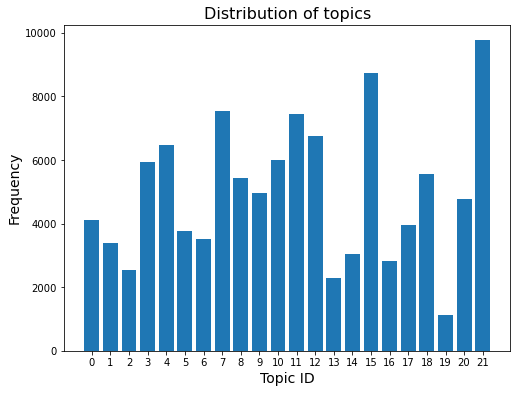

In [45]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()